# Data Exploration, Preprocessing, Feature Engineering

In [1]:
# IMPORT LIBS AND UTILS FUNCS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from datetime import datetime


def detect_outliers_iqr(df, column):
    """detects outliers using the Interquartile Range (IQR) method
    IQR (Interquartile Range): Remove data points outside a specified range (usually 1.5 times the IQR).

    Args:
        df (_type_): _description_
        column (_type_): _description_

    Returns:
        _type_: _description_
    """
    # Calculate IQR
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    # Define upper and lower bounds to identify outliers
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliner_num = len(outliers)
    return lower_bound, upper_bound, outliner_num, outliers

/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ipykernel_14218/656057282.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Dataset of loan_data.csv

In [2]:
# Load the data
file_name = "../data/loan_data.csv"
loan_data = pd.read_csv(file_name)

# Turn date into datetime object and rename it for clearification
loan_data["date"] = pd.to_datetime(loan_data["date"]) 
loan_data.rename(columns={"date": "loan_date"}, inplace=True)

loan_data

,loan_id,cust_id,loan_date,loan_reason,loan_term,requested_amount,installment,number_loans_accounts,number_accounts
0,223001,0,2017-09-01,Personal,36,50000,1833.33,0,1
1,222998,1,2018-09-01,Car,36,10000,352.78,0,1
2,222995,2,2016-04-01,Financial,24,5000,287.50,0,1
3,222992,3,2016-08-01,Car,24,7000,370.42,0,1
4,222989,4,2017-06-01,Car,72,4000,70.56,1,1
...,...,...,...,...,...,...,...,...,...
39995,103016,39995,2017-12-01,Personal,72,7000,128.33,0,1
39996,103013,39996,2016-08-01,Car,24,10000,529.17,1,2
39997,103010,39997,2018-08-01,Housing,48,15000,359.38,0,2
39998,103007,39998,2017-07-01,Financial,60,10000,230.00,0,4


### Feature Engineering

In [3]:
# Check total payback amount if there is any outlier.
loan_data["payback_amount"] = loan_data["loan_term"] * loan_data["installment"]
assert len(loan_data[(loan_data["payback_amount"] <= loan_data["requested_amount"])]) == 0, "WARNING: There are negative interest rates, make some checks."

In [4]:
loan_data["overall_interest_percentage"] = round(100 * (loan_data["payback_amount"] - loan_data["requested_amount"]) / \
    loan_data["requested_amount"], 1)
loan_data["overall_interest_percentage"].unique()
# IT IS STRANGE THAT THERE ARE HIGH INTEREST RATE, BUT I WILL NOT GO INTO ROOT CAUSE OF THIS DUE TO THE LACK OF 
# DOMAIN KNOWLEDGE

array([ 32. ,  27. ,  38. ,  15. , 187.5,  98. , 230. ,  52.4, 154. ,
       107. , 535. ,  90.5, 164. , 217.5,  58.4, 245. , 130. ,  72.5,
        65.6, 296. , 560. , 281. , 176. , 590. , 314. , 475. ])

### EDA

In [5]:
# Check if customers and loans are unique
print(f"Number of unique customers: {loan_data['cust_id'].nunique()}")
assert loan_data["cust_id"].nunique() == len(loan_data), "WARNING: \
    There exist customers who have multiple loans."
print(f"Number of unique loan IDs: {loan_data['loan_id'].nunique()}")
assert loan_data["loan_id"].nunique() == len(loan_data), "ERROR: \
    There exist same load ID multiple times."

Number of unique customers: 40000
Number of unique loan IDs: 40000


In [6]:
# Check data types
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   loan_id                      40000 non-null  int64         
 1   cust_id                      40000 non-null  int64         
 2   loan_date                    40000 non-null  datetime64[ns]
 3   loan_reason                  40000 non-null  object        
 4   loan_term                    40000 non-null  int64         
 5   requested_amount             40000 non-null  int64         
 6   installment                  40000 non-null  float64       
 7   number_loans_accounts        40000 non-null  int64         
 8   number_accounts              40000 non-null  int64         
 9   payback_amount               40000 non-null  float64       
 10  overall_interest_percentage  40000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6

In [7]:
# Calculate the percentage of missing values for each column
missing_percentage = (loan_data.isna().mean() * 100).round(2)

# Display the result
print("Missing Value Percentage for Each Column:")
print(missing_percentage)

Missing Value Percentage for Each Column:
loan_id                        0.0
cust_id                        0.0
loan_date                      0.0
loan_reason                    0.0
loan_term                      0.0
requested_amount               0.0
installment                    0.0
number_loans_accounts          0.0
number_accounts                0.0
payback_amount                 0.0
overall_interest_percentage    0.0
dtype: float64


In [8]:
# Define numerical features
num_feats = ["loan_term", "requested_amount", "installment", "number_accounts", \
    "number_loans_accounts", "payback_amount", "overall_interest_percentage"]

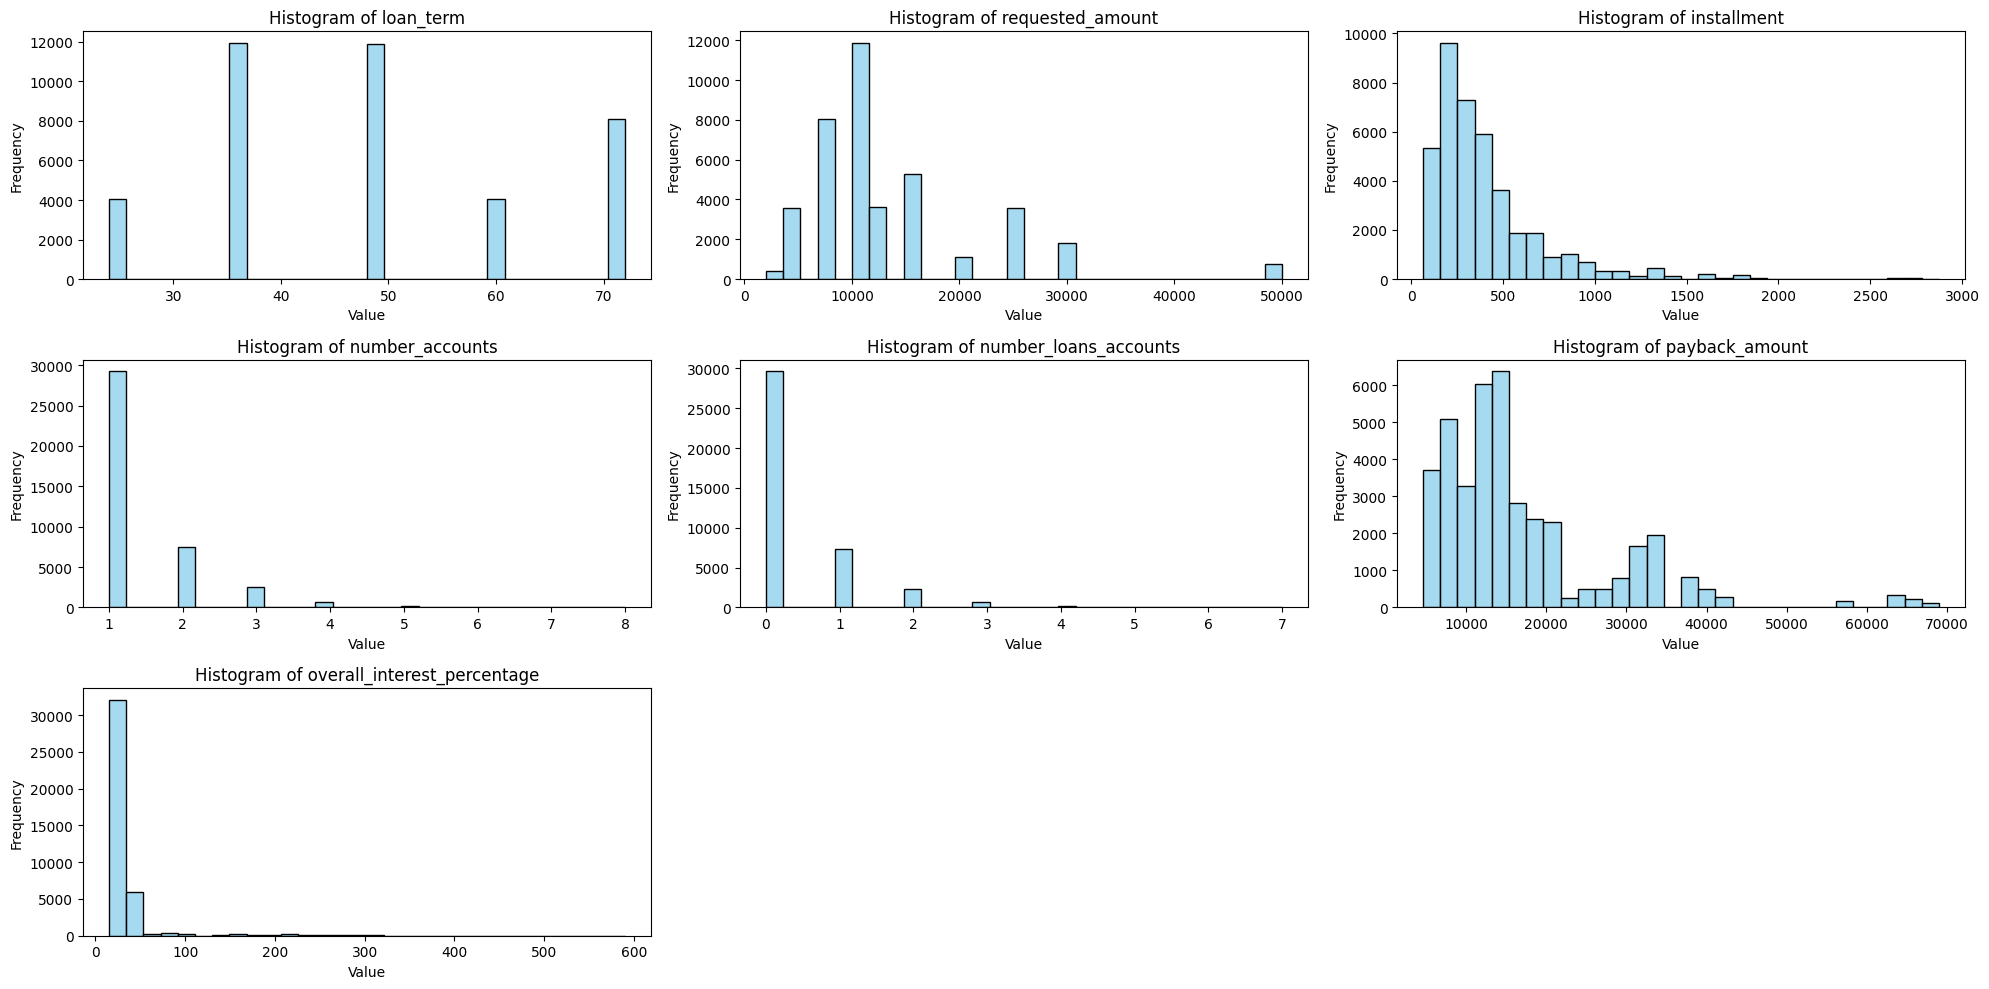

In [9]:
# Plot histogram plots for numeric features
plt.figure(figsize=(20, 10))
for i, num_feat in enumerate(num_feats, 1):
    plt.subplot(3, 3, i)
    sns.histplot(loan_data[num_feat], kde=False, bins=30, color="skyblue")
    plt.title(f"Histogram of {num_feat}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# From histograms, all numeric features except installement, payback_amount, 
# and overall_interest_percentage features are like a categorical feature since they seem to have
# very less discrete numbers. That's why I will examine them also like they are categorical.

# installement and payback_amount HAS SKEWED DISTRIBUTION:
# Skewness refers to the asymmetry or lack of symmetry in the distribution of a feature. 

# SOME CHECKS ON WEB FOR REQUESTED LOAN AMOUNT ON EUROPE: 
# The maximum amount that can be borrowed as a personal loan in the Netherlands can vary 
# significantly depending on the bank or financial institution, the borrower's financial situation, 
# creditworthiness, income, employment status, and other factors. Personal loan amounts can typically 
# range from a few thousand euros to tens of thousands of euros. Some banks may offer personal loans 
# up to €50,000, €75,000, or even more for highly qualified borrowers. 

/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupB

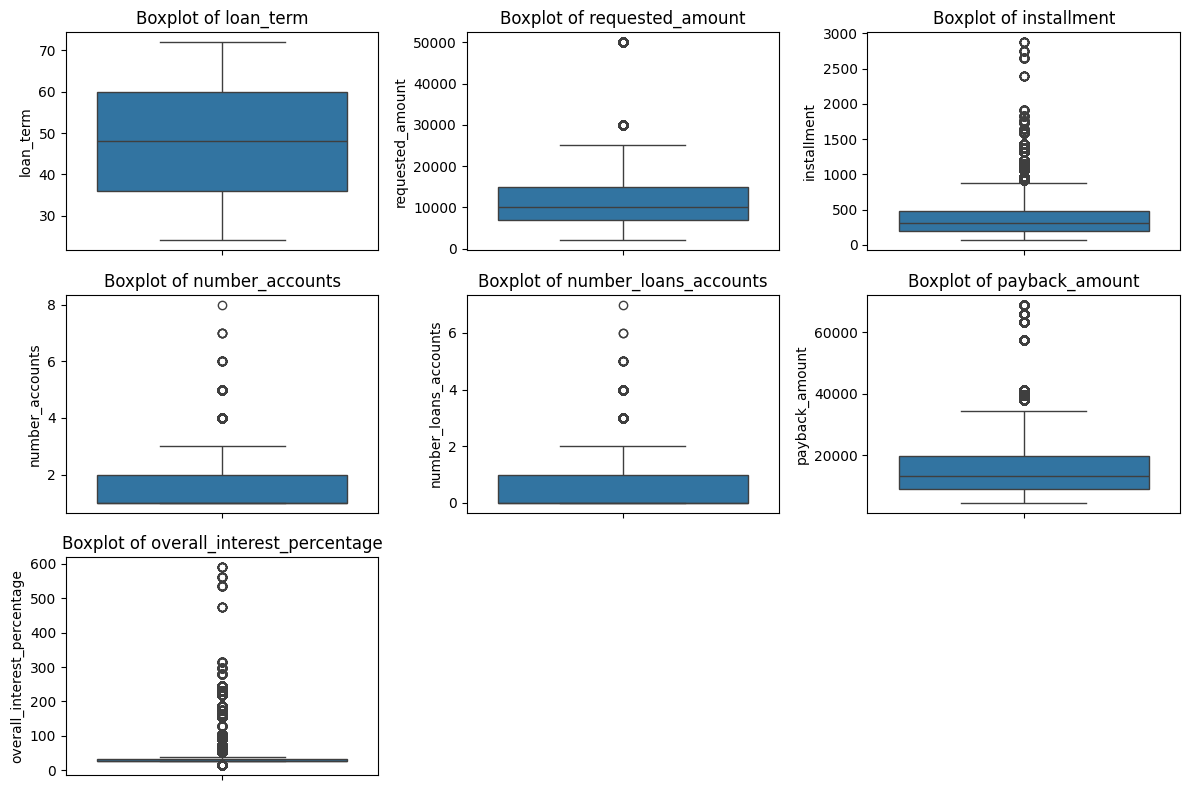

In [10]:
# Plot boxplots for each column to visualize the outliers
plt.figure(figsize=(12, 8))
for i, num_feat in enumerate(num_feats, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=loan_data[num_feat])
    plt.title(f"Boxplot of {num_feat}")

plt.tight_layout()
plt.show()

In [11]:
# Find and print outliers for each numeric features
for num_feat in num_feats:
    lower_bound, upper_bound, outliner_num, _ = detect_outliers_iqr(loan_data, num_feat)
    print(f"Total number of outliers for {num_feat}: {outliner_num}")
    print(f"Non-Outlier bounds for {num_feat}: [{lower_bound}-{upper_bound}]")
    print(50*"-")

Total number of outliers for loan_term: 0
Non-Outlier bounds for loan_term: [0.0-96.0]
--------------------------------------------------
Total number of outliers for requested_amount: 2556
Non-Outlier bounds for requested_amount: [-5000.0-27000.0]
--------------------------------------------------
Total number of outliers for installment: 2561
Non-Outlier bounds for installment: [-237.505-909.175]
--------------------------------------------------
Total number of outliers for number_accounts: 798
Non-Outlier bounds for number_accounts: [-0.5-3.5]
--------------------------------------------------
Total number of outliers for number_loans_accounts: 770
Non-Outlier bounds for number_loans_accounts: [-1.5-2.5]
--------------------------------------------------
Total number of outliers for payback_amount: 2434
Non-Outlier bounds for payback_amount: [-6600.0-35640.0]
--------------------------------------------------
Total number of outliers for overall_interest_percentage: 9832
Non-Outlie

In [12]:
# Define categorical and behaving like categorical features
cat_feat = ["loan_reason"]
like_cat_feat = ["loan_term", "requested_amount", "number_accounts", \
    "number_loans_accounts"]
cat_feats = cat_feat + like_cat_feat

/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ipykernel_14218/2328537514.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cat_feat, data=loan_data, palette="viridis")
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_

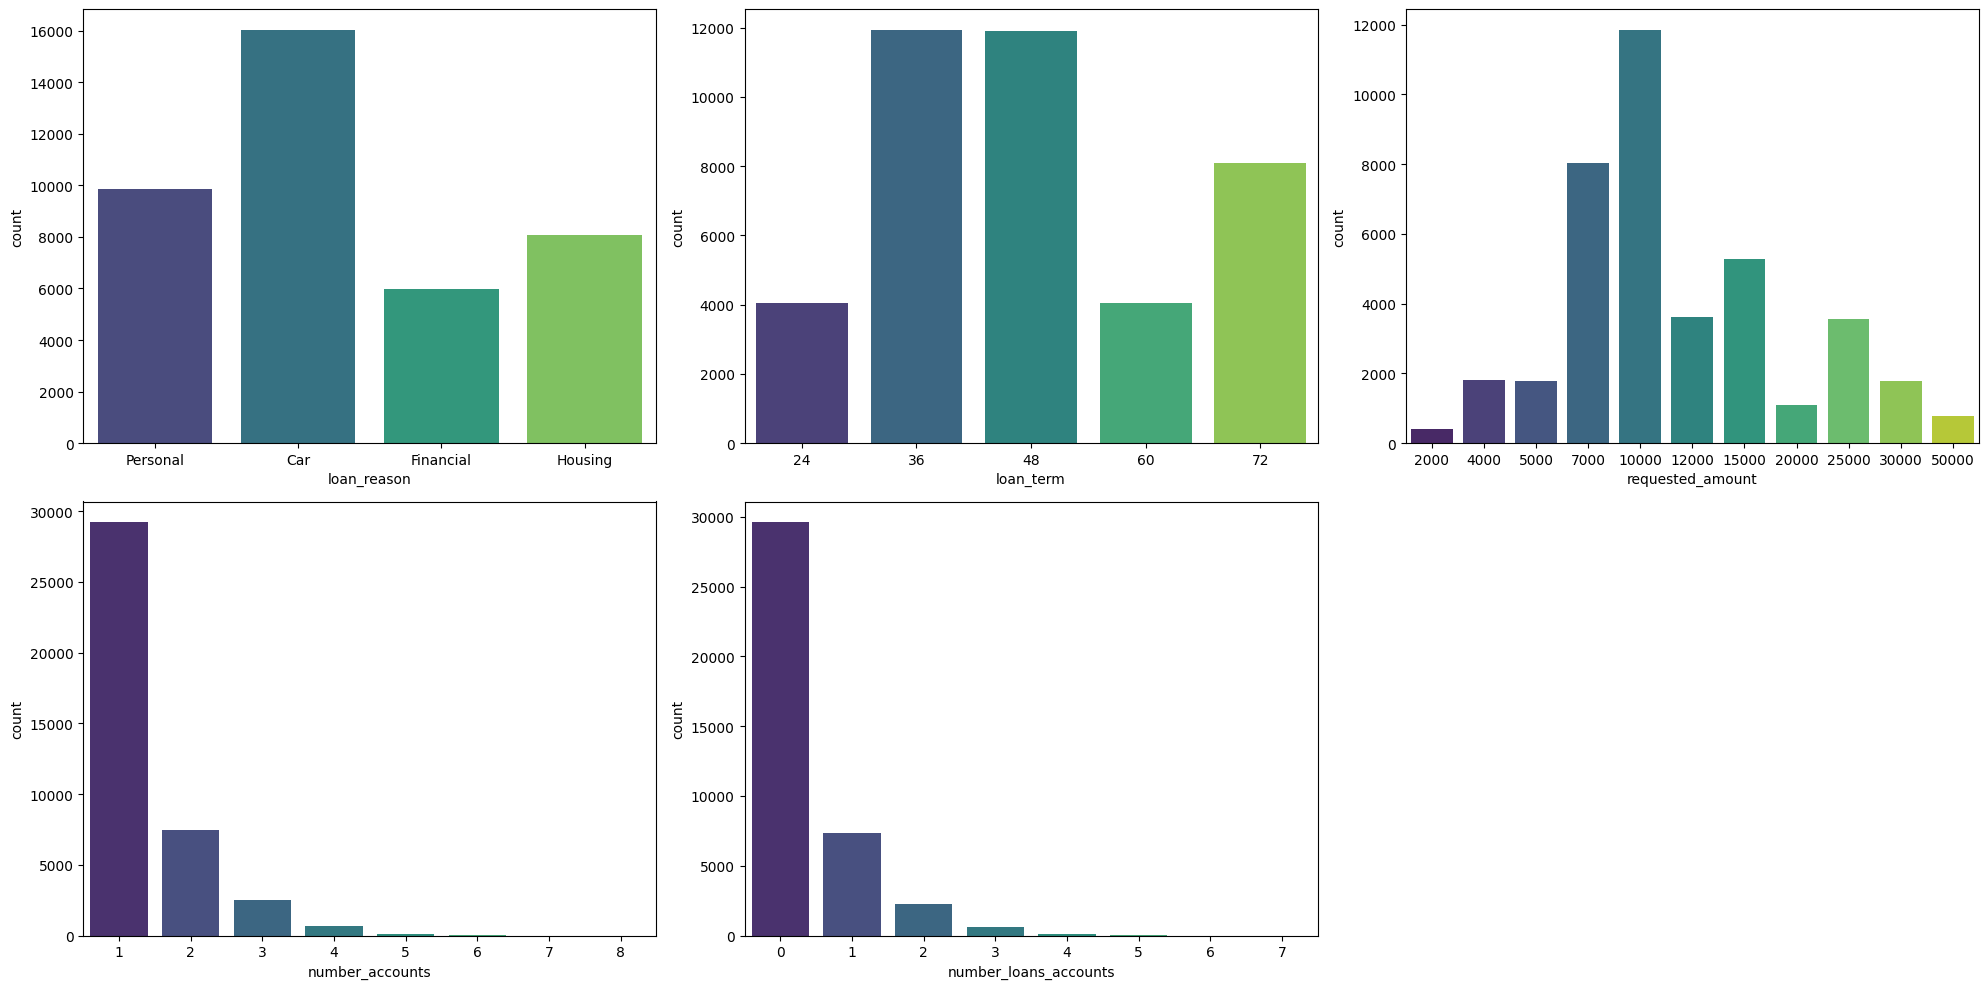

In [13]:
# Plot bar plots for value counts for each column
plt.figure(figsize=(20, 10))
for idx, cat_feat in enumerate(cat_feats, 1):
    plt.subplot(2, 3, idx)
    sns.countplot(x=cat_feat, data=loan_data, palette="viridis")

plt.tight_layout()
plt.show()

### More Feature Engineering

Rare categories in features can sometimes be grouped together into a single "Other" category to simplify the feature space and potentially improve model performance.

From the IQR outlier analysis, category values bigger than 3 are outlier in "number_accounts" and also category values bigger than 2 are outlier in "number_loans_accounts". 
I guess that the distinction between 3, 4, 5, 6, 7, 8 in "number_accounts" feature is not meaningful, and not important for my analysis, combining them may not lead to a loss of valuable information. It is also the same for "number_loans_accounts" feature. That's why I will group them together into a single category. In this way, these two numerical features will be become categorical features.

In [14]:
loan_data["cat_number_accounts"] = loan_data["number_accounts"].apply(lambda row: 3 if row > 3 else row)
loan_data["cat_number_loans_accounts"] = loan_data["number_loans_accounts"].apply(lambda row: 2 if row > 2 else row)

Let's eliminate outliers in "requested_amount", "installment", "payback_amount" features.

#### Some checks on web for yearly interest percentage for personal loans in europe:
Interest rates for personal loans in Europe can vary widely depending on the country, the lender, the borrower's creditworthiness, the loan amount, and the term of the loan. Typical interest rates for personal loans in Europe might range from around 3% to 20% or more per annum.

I will not eliminate outliers in "overall_interest_percentage" since the artificial data can be generated on purpose and I don't have domain information about interest rates in the country where the data belongs, the information on web is not enough for me to confidently remove outliers.

In [15]:
# First explore the number of outliers belongs to all features.
_, _, _, outliers_requested_amount = detect_outliers_iqr(loan_data, "requested_amount")
_, _, _, outliers_installment = detect_outliers_iqr(loan_data, "installment")
_, _, _, outliers_payback_amount = detect_outliers_iqr(loan_data, "payback_amount")

In [16]:
# Take the union of these tree outlier spaces
outlier_union = pd.concat([outliers_requested_amount, outliers_installment, \
    outliers_payback_amount]).drop_duplicates(keep="first")
outlier_union

,loan_id,cust_id,loan_date,loan_reason,loan_term,requested_amount,installment,number_loans_accounts,number_accounts,payback_amount,overall_interest_percentage,cat_number_accounts,cat_number_loans_accounts
0,223001,0,2017-09-01,Personal,36,50000,1833.33,0,1,65999.88,32.0,1,0
53,222842,53,2017-05-01,Car,36,50000,1763.89,1,1,63500.04,27.0,1,1
68,222797,68,2018-03-01,Financial,48,30000,862.50,0,1,41400.00,38.0,1,0
93,222722,93,2016-01-01,Financial,36,30000,1150.00,0,1,41400.00,38.0,1,0
107,222680,107,2016-01-01,Personal,36,50000,1833.33,0,2,65999.88,32.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37957,109130,37957,2018-01-01,Car,72,10000,881.94,0,1,63499.68,535.0,1,0
38120,108641,38120,2018-10-01,Financial,72,10000,575.00,0,1,41400.00,314.0,1,0
38238,108287,38238,2016-08-01,Car,72,10000,529.17,0,1,38100.24,281.0,1,0
38493,107522,38493,2017-07-01,Financial,72,10000,575.00,0,1,41400.00,314.0,1,0


In [17]:
# Eliminate outliers from loan_data
loan_data = pd.concat([loan_data, outlier_union]).drop_duplicates(keep=False)
loan_data

,loan_id,cust_id,loan_date,loan_reason,loan_term,requested_amount,installment,number_loans_accounts,number_accounts,payback_amount,overall_interest_percentage,cat_number_accounts,cat_number_loans_accounts
1,222998,1,2018-09-01,Car,36,10000,352.78,0,1,12700.08,27.0,1,0
2,222995,2,2016-04-01,Financial,24,5000,287.50,0,1,6900.00,38.0,1,0
3,222992,3,2016-08-01,Car,24,7000,370.42,0,1,8890.08,27.0,1,0
4,222989,4,2017-06-01,Car,72,4000,70.56,1,1,5080.32,27.0,1,1
5,222986,5,2018-04-01,Car,48,10000,264.58,2,1,12699.84,27.0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,103016,39995,2017-12-01,Personal,72,7000,128.33,0,1,9239.76,32.0,1,0
39996,103013,39996,2016-08-01,Car,24,10000,529.17,1,2,12700.08,27.0,2,1
39997,103010,39997,2018-08-01,Housing,48,15000,359.38,0,2,17250.24,15.0,2,0
39998,103007,39998,2017-07-01,Financial,60,10000,230.00,0,4,13800.00,38.0,3,0


In [18]:
loan_data.columns

Index(['loan_id', 'cust_id', 'loan_date', 'loan_reason', 'loan_term',
       'requested_amount', 'installment', 'number_loans_accounts',
       'number_accounts', 'payback_amount', 'overall_interest_percentage',
       'cat_number_accounts', 'cat_number_loans_accounts'],
      dtype='object')

In [19]:
# Save the modified DataFrame to a new CSV file
# Since payback_amount, installment, and loan_term are dependent on each other, I will only keep
# two of them: payback_amount and installment. I believe these two have more crucial information
# for identifying default loans.
loan_data[["loan_id", "cust_id", "loan_reason", "requested_amount", \
    "payback_amount", "installment", "cat_number_accounts", "cat_number_loans_accounts"]].to_csv(\
        "../processed_data/loan_data.csv", index=False)

## Dataset of customer_data.csv

In [20]:
# Load the data
file_name = "../data/customer_data.csv"
customer_data = pd.read_csv(file_name)

customer_data

,cust_id,gender,religion,employment,postal_code,birth_date,joined_ING_date,number_client_calls_to_ING,number_client_calls_from_ING
0,0,M,U,Public Sector,20,1985-09-01,2014-04-01,0,0
1,1,M,C,Private Sector,30,1982-09-01,2015-11-01,0,6
2,2,M,C,Private Sector,20,1974-04-01,2012-03-01,0,0
3,3,F,J,Unemployed,10,1977-08-01,2013-02-01,5,6
4,4,M,U,Private Sector,70,1979-06-01,2016-02-01,0,0
...,...,...,...,...,...,...,...,...,...
39995,39995,M,J,Private Sector,50,1980-12-01,2014-11-01,2,2
39996,39996,M,J,Private Sector,40,1961-08-01,2015-10-01,0,1
39997,39997,F,J,Self-employed,20,1992-08-01,2016-03-01,0,1
39998,39998,M,U,Public Sector,40,1975-07-01,2013-08-01,4,7


In [21]:
# Convert the 'date' column to datetime format for easier manipulation
customer_data["birth_date"] = pd.to_datetime(customer_data["birth_date"])
customer_data["joined_ING_date"] = pd.to_datetime(customer_data["joined_ING_date"])

In [22]:
customer_data = customer_data.merge(loan_data[["cust_id", "loan_date"]], how="left", on=["cust_id"])
customer_data

,cust_id,gender,religion,employment,postal_code,birth_date,joined_ING_date,number_client_calls_to_ING,number_client_calls_from_ING,loan_date
0,0,M,U,Public Sector,20,1985-09-01,2014-04-01,0,0,NaT
1,1,M,C,Private Sector,30,1982-09-01,2015-11-01,0,6,2018-09-01
2,2,M,C,Private Sector,20,1974-04-01,2012-03-01,0,0,2016-04-01
3,3,F,J,Unemployed,10,1977-08-01,2013-02-01,5,6,2016-08-01
4,4,M,U,Private Sector,70,1979-06-01,2016-02-01,0,0,2017-06-01
...,...,...,...,...,...,...,...,...,...,...
39995,39995,M,J,Private Sector,50,1980-12-01,2014-11-01,2,2,2017-12-01
39996,39996,M,J,Private Sector,40,1961-08-01,2015-10-01,0,1,2016-08-01
39997,39997,F,J,Self-employed,20,1992-08-01,2016-03-01,0,1,2018-08-01
39998,39998,M,U,Public Sector,40,1975-07-01,2013-08-01,4,7,2017-07-01


### Feature Engineering

In [23]:
# Define a function to calculate age from birth_date at the time of loan disbursed. 
def calculate_age(birth_date, loan_date):
    age = loan_date.year - birth_date.year - ((loan_date.month, loan_date.day) < (birth_date.month, birth_date.day))
    return age

# Define a function to calculate the length of relationship with the bank from \
# joined_ING_date at the time of loan disbursed
def calculate_relationship_length(joined_date, loan_date):
    relation_len = loan_date.year - joined_date.year - ((loan_date.month, loan_date.day) < (joined_date.month, joined_date.day))
    return relation_len

In [24]:
# Apply the functions to the DataFrame
customer_data["age"] = customer_data.apply(lambda row: \
    calculate_age(row["birth_date"], row["loan_date"]), axis=1)
customer_data["relationship_length"] = customer_data.apply(lambda row: \
    calculate_age(row["joined_ING_date"], row["loan_date"]), axis=1)

# Print the first and last 5 rows to check the data
customer_data

,cust_id,gender,religion,employment,postal_code,birth_date,joined_ING_date,number_client_calls_to_ING,number_client_calls_from_ING,loan_date,age,relationship_length
0,0,M,U,Public Sector,20,1985-09-01,2014-04-01,0,0,NaT,NaN,NaN
1,1,M,C,Private Sector,30,1982-09-01,2015-11-01,0,6,2018-09-01,36.0,2.0
2,2,M,C,Private Sector,20,1974-04-01,2012-03-01,0,0,2016-04-01,42.0,4.0
3,3,F,J,Unemployed,10,1977-08-01,2013-02-01,5,6,2016-08-01,39.0,3.0
4,4,M,U,Private Sector,70,1979-06-01,2016-02-01,0,0,2017-06-01,38.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,M,J,Private Sector,50,1980-12-01,2014-11-01,2,2,2017-12-01,37.0,3.0
39996,39996,M,J,Private Sector,40,1961-08-01,2015-10-01,0,1,2016-08-01,55.0,0.0
39997,39997,F,J,Self-employed,20,1992-08-01,2016-03-01,0,1,2018-08-01,26.0,2.0
39998,39998,M,U,Public Sector,40,1975-07-01,2013-08-01,4,7,2017-07-01,42.0,3.0


In [25]:
# Drop the original date columns as they are no longer needed
customer_data.drop(columns=["birth_date", "joined_ING_date", "loan_date"], inplace=True)

### EDA

In [26]:
# Check data types
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cust_id                       40000 non-null  int64  
 1   gender                        40000 non-null  object 
 2   religion                      40000 non-null  object 
 3   employment                    40000 non-null  object 
 4   postal_code                   40000 non-null  int64  
 5   number_client_calls_to_ING    40000 non-null  int64  
 6   number_client_calls_from_ING  40000 non-null  int64  
 7   age                           36176 non-null  float64
 8   relationship_length           36176 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 2.7+ MB


In [27]:
# Calculate the percentage of missing values for each column
missing_percentage = (customer_data.isna().mean() * 100).round(2)

# Display the result
print("Missing Value Percentage for Each Column:")
print(missing_percentage)

# NOT THAT MUCH MISSING VALUE IN age and relationship_length 
# That's why I will examine then in the final merged dataset.

Missing Value Percentage for Each Column:
cust_id                         0.00
gender                          0.00
religion                        0.00
employment                      0.00
postal_code                     0.00
number_client_calls_to_ING      0.00
number_client_calls_from_ING    0.00
age                             9.56
relationship_length             9.56
dtype: float64


In [28]:
num_feats = ["age", "relationship_length", "number_client_calls_to_ING", "number_client_calls_from_ING"]

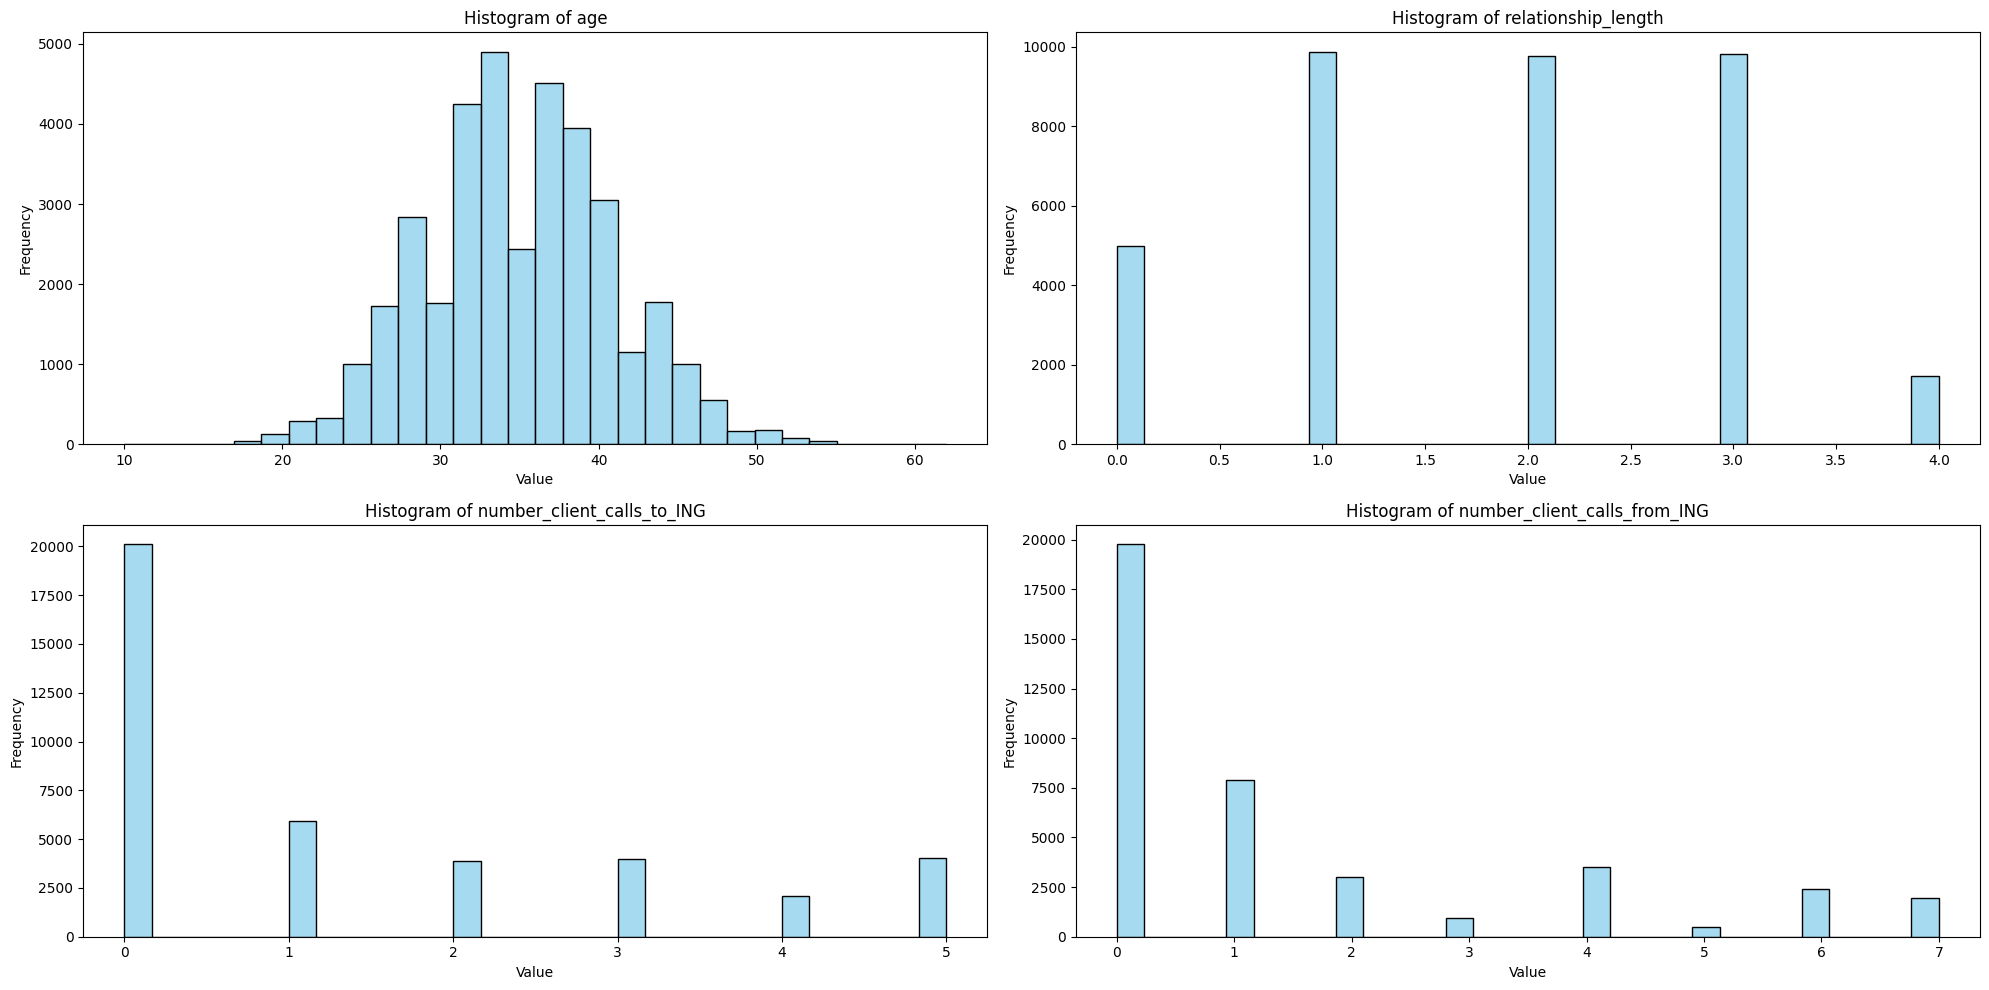

In [29]:
# Plot histogram plots for numeric features
plt.figure(figsize=(20, 10))
for i, num_feat in enumerate(num_feats, 1):
    plt.subplot(2, 2, i)
    sns.histplot(customer_data[num_feat], kde=False, bins=30, color="skyblue")
    plt.title(f"Histogram of {num_feat}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# From histograms, features such as number_client_calls_to_ING and number_client_calls_from_ING 
# are like a categorical feature since they seem to have very less discrete numbers. 
# That's why I will examine them also like they are categorical.


In [30]:
# Find and print outliers for each numerical feature
for num_feat in num_feats:
    lower_bound, upper_bound, outliner_num, _ = detect_outliers_iqr(customer_data, num_feat)
    print(f"Total number of outliers for {num_feat}: {outliner_num}")
    print(f"Non-Outlier bounds for {num_feat}: [{lower_bound}-{upper_bound}]")
    print(50*"-")

Total number of outliers for age: 186
Non-Outlier bounds for age: [19.0-51.0]
--------------------------------------------------
Total number of outliers for relationship_length: 0
Non-Outlier bounds for relationship_length: [-2.0-6.0]
--------------------------------------------------
Total number of outliers for number_client_calls_to_ING: 0
Non-Outlier bounds for number_client_calls_to_ING: [-4.5-7.5]
--------------------------------------------------
Total number of outliers for number_client_calls_from_ING: 4367
Non-Outlier bounds for number_client_calls_from_ING: [-3.0-5.0]
--------------------------------------------------


In [31]:
cat_feats = ["gender", "religion", "employment", "postal_code"]
like_cat_feats = ["number_client_calls_to_ING", "number_client_calls_from_ING"]
cat_feats = cat_feats + like_cat_feats

/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ipykernel_14218/501408738.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=cat_feat, data=customer_data, palette="viridis")
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  da

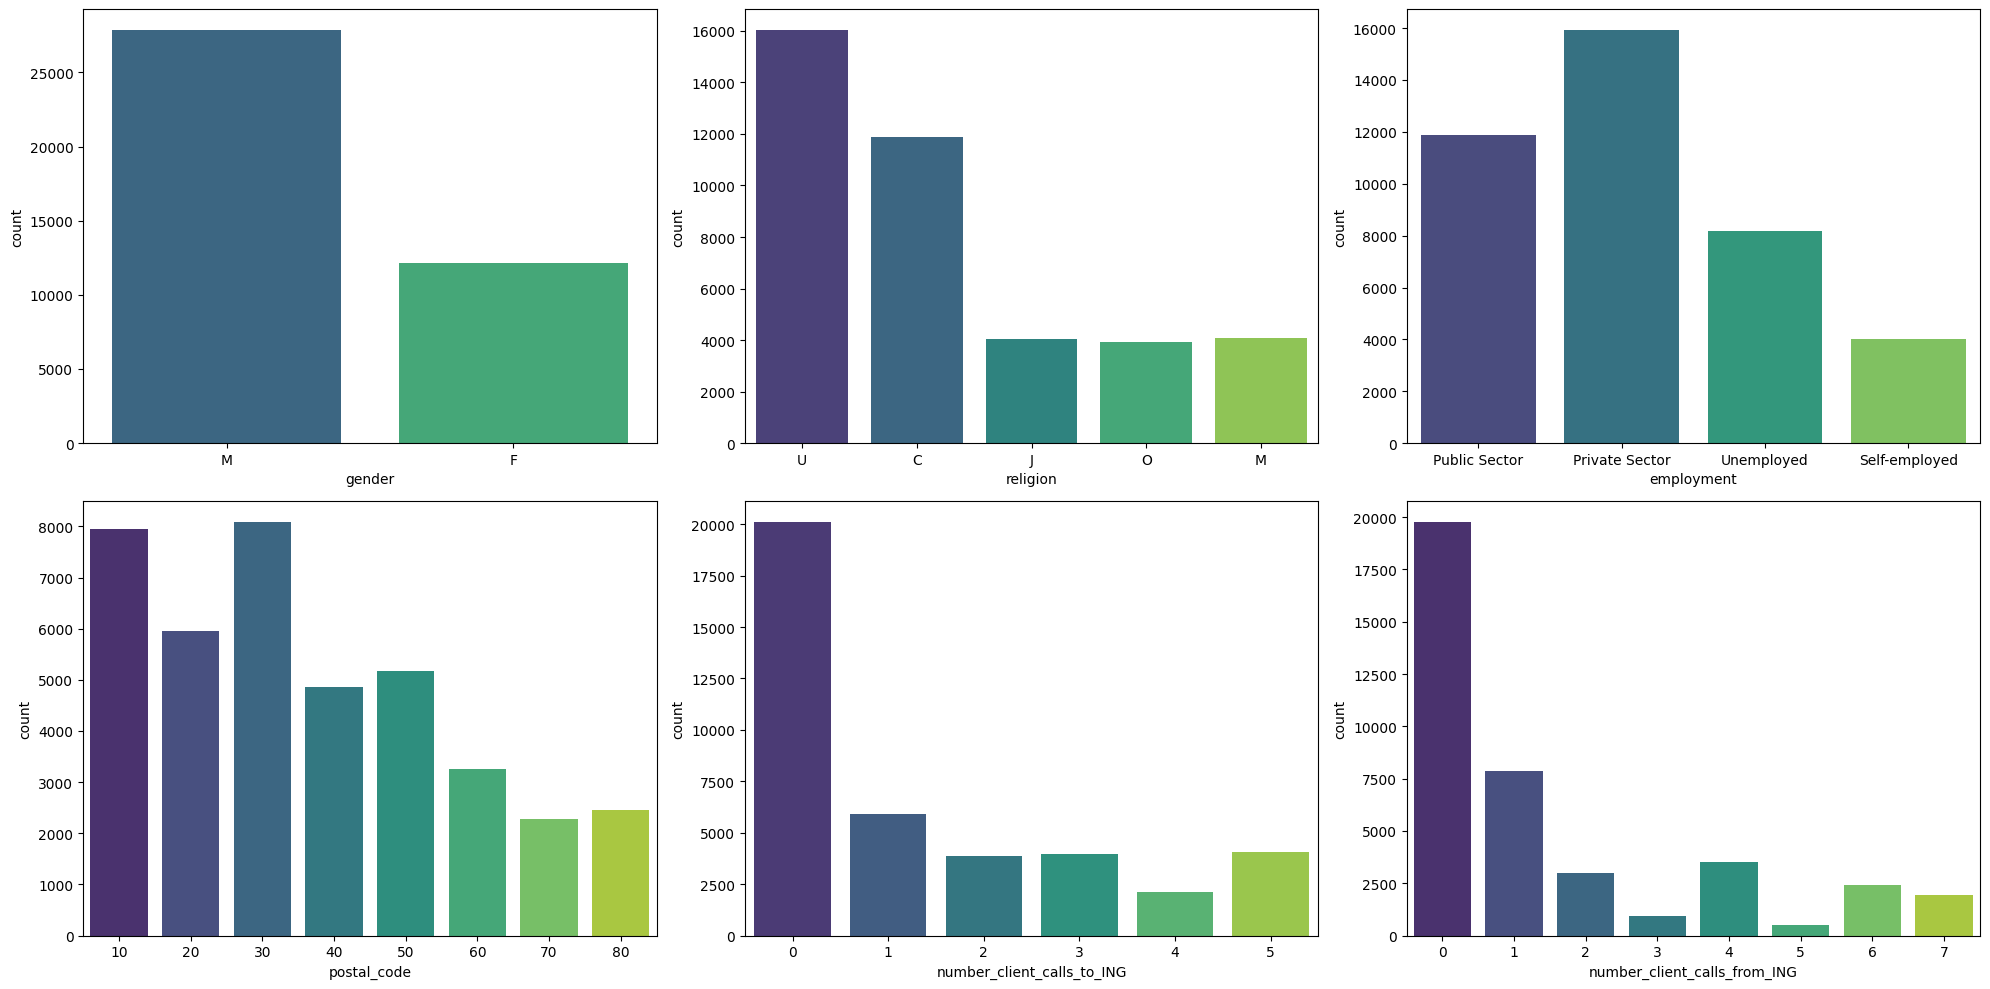

In [32]:
# Plot bar plots for value counts for each categorical feature
plt.figure(figsize=(20, 10))
for idx, cat_feat in enumerate(cat_feats, 1):
    plt.subplot(2, 3, idx)
    sns.countplot(x=cat_feat, data=customer_data, palette="viridis")

plt.tight_layout()
plt.show()

### More Feature Engineering

From the IQR outlier analysis, category values bigger than 5 are outlier in "number_client_calls_from_ING" and also age not in the range of [19.0, 51.0] are outlier in "age". 
I guess that the distinction between 5, 6, 7 in "number_client_calls_from_ING" feature is not meaningful, and not important for my analysis, combining them may not lead to a loss of valuable information.

In [33]:
customer_data["cat_number_client_calls_from_ING"] = customer_data["number_client_calls_from_ING"].\
    apply(lambda row: 5 if row > 5 else row)

In [34]:
# First explore the number of outliers belongs to age.
_, _, _, outliers_age = detect_outliers_iqr(customer_data, "age")

In [35]:
# Eliminate outliers from customer_data
customer_data = pd.concat([customer_data, outliers_age]).drop_duplicates(keep=False)
customer_data

,cust_id,gender,religion,employment,postal_code,number_client_calls_to_ING,number_client_calls_from_ING,age,relationship_length,cat_number_client_calls_from_ING
0,0,M,U,Public Sector,20,0,0,NaN,NaN,0
1,1,M,C,Private Sector,30,0,6,36.0,2.0,5
2,2,M,C,Private Sector,20,0,0,42.0,4.0,0
3,3,F,J,Unemployed,10,5,6,39.0,3.0,5
4,4,M,U,Private Sector,70,0,0,38.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...
39994,39994,F,O,Unemployed,30,0,0,38.0,3.0,0
39995,39995,M,J,Private Sector,50,2,2,37.0,3.0,2
39997,39997,F,J,Self-employed,20,0,1,26.0,2.0,1
39998,39998,M,U,Public Sector,40,4,7,42.0,3.0,5


In [36]:
customer_data.columns

Index(['cust_id', 'gender', 'religion', 'employment', 'postal_code',
       'number_client_calls_to_ING', 'number_client_calls_from_ING', 'age',
       'relationship_length', 'cat_number_client_calls_from_ING'],
      dtype='object')

In [37]:
# Save the modified DataFrame to a new CSV file
customer_data[["cust_id", "gender", "religion", "employment", \
    "postal_code", "number_client_calls_to_ING", "cat_number_client_calls_from_ING", \
        "age", "relationship_length"]].to_csv(\
        "../processed_data/customer_data.csv", index=False)

## Dataset of customer_financials.csv

In [38]:
# Load the data
file_name = "../data/customer_financials.csv"
finance_data = pd.read_csv(file_name, delimiter=";")

finance_data

,cust_id,date,salary,current_acc_balance,saving_acc_balance,credit_card_balance
0,0,2016-01-01,1330.55,1844.15,2522.59,NaN
1,0,2016-02-01,1317.71,1907.33,2722.08,NaN
2,0,2016-03-01,1334.56,1890.58,2801.35,NaN
3,0,2016-04-01,1330.48,1958.23,2819.61,NaN
4,0,2016-05-01,1330.27,1874.69,3093.47,NaN
...,...,...,...,...,...,...
1324867,39999,2018-08-01,2384.63,-2811.81,0.00,1891.02
1324868,39999,2018-09-01,2403.01,-2923.62,0.00,1905.20
1324869,39999,2018-10-01,2379.44,-2992.78,0.00,1853.04
1324870,39999,2018-11-01,2362.81,-3094.57,0.00,1873.68


### AVOID POSSIBLE DATA LEAKAGE

In [39]:
# Convert the 'date' column to datetime format for easier manipulation
finance_data["date"] = pd.to_datetime(finance_data["date"])
finance_data = finance_data.merge(loan_data[["cust_id", "loan_date"]], how="left", on=["cust_id"])
finance_data

,cust_id,date,salary,current_acc_balance,saving_acc_balance,credit_card_balance,loan_date
0,0,2016-01-01,1330.55,1844.15,2522.59,NaN,NaT
1,0,2016-02-01,1317.71,1907.33,2722.08,NaN,NaT
2,0,2016-03-01,1334.56,1890.58,2801.35,NaN,NaT
3,0,2016-04-01,1330.48,1958.23,2819.61,NaN,NaT
4,0,2016-05-01,1330.27,1874.69,3093.47,NaN,NaT
...,...,...,...,...,...,...,...
1324867,39999,2018-08-01,2384.63,-2811.81,0.00,1891.02,2017-03-01
1324868,39999,2018-09-01,2403.01,-2923.62,0.00,1905.20,2017-03-01
1324869,39999,2018-10-01,2379.44,-2992.78,0.00,1853.04,2017-03-01
1324870,39999,2018-11-01,2362.81,-3094.57,0.00,1873.68,2017-03-01


In [40]:
# Check if there exists any data that will cause leakage
finance_data["is_after_loan_date"] = finance_data["date"] > finance_data["loan_date"]
print(f"Number of data that will cause possible data leakage: {finance_data['is_after_loan_date'].sum()}") # 

Number of data that will cause possible data leakage: 629561


In [41]:
# Drop data if it belongs to the date after the load is disbursed
finance_data = finance_data[~(finance_data["is_after_loan_date"] == 1)]
assert finance_data["is_after_loan_date"].sum() == 0, "ERROR: There are still some data likage" # Last check
finance_data

,cust_id,date,salary,current_acc_balance,saving_acc_balance,credit_card_balance,loan_date,is_after_loan_date
0,0,2016-01-01,1330.55,1844.15,2522.59,NaN,NaT,False
1,0,2016-02-01,1317.71,1907.33,2722.08,NaN,NaT,False
2,0,2016-03-01,1334.56,1890.58,2801.35,NaN,NaT,False
3,0,2016-04-01,1330.48,1958.23,2819.61,NaN,NaT,False
4,0,2016-05-01,1330.27,1874.69,3093.47,NaN,NaT,False
...,...,...,...,...,...,...,...,...
1324846,39999,2016-11-01,2406.26,-863.34,0.00,935.53,2017-03-01,False
1324847,39999,2016-12-01,2365.18,-956.06,0.00,1020.60,2017-03-01,False
1324848,39999,2017-01-01,2408.09,-1059.91,0.00,1052.62,2017-03-01,False
1324849,39999,2017-02-01,2668.21,-1171.31,0.00,1122.46,2017-03-01,False


### Feature Engineering

I can calculate average_monthly_balance by taking the mean of current_account_balance and saving_acc_balance. But, the resulting average_monthly_balance is depend on these two. That's why no need.

In [42]:
# Calculate the average monthly balance for each customer
finance_data["monthly_balance"] = (finance_data["current_acc_balance"] + finance_data["saving_acc_balance"]) / 2
#

/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ipykernel_14218/4175224982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finance_data["monthly_balance"] = (finance_data["current_acc_balance"] + finance_data["saving_acc_balance"]) / 2


In [43]:
# Calculate debt-to-income ratio, assuming that the debt is the credit card balance and income is the salary
finance_data["debt_to_income_ratio"] = finance_data["credit_card_balance"] / finance_data["salary"].replace({0: pd.NA})

/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ipykernel_14218/3462765498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finance_data["debt_to_income_ratio"] = finance_data["credit_card_balance"] / finance_data["salary"].replace({0: pd.NA})


In [44]:
# Group the data by 'cust_id' and calculate the mean for each financial product
customer_averages = finance_data.groupby("cust_id").mean()
#Rename the columns to reflect that these are averages
customer_averages.rename(columns={
    "salary": "average_salary",
    "current_acc_balance": "average_current_acc_balance",
    "saving_acc_balance": "average_saving_account_balance",
    "credit_card_balance": "average_credit_card_balance",
    "debt_to_income_ratio": "average_debt_to_income_ratio",
    "monthly_balance": "average_monthly_balance"
    }, inplace=True)

# Reset the index so 'cust_id' becomes a column again
customer_averages.reset_index(inplace=True)

customer_averages

,cust_id,date,average_salary,average_current_acc_balance,average_saving_account_balance,average_credit_card_balance,loan_date,is_after_loan_date,average_monthly_balance,average_debt_to_income_ratio
0,0,2017-06-16 10:40:00.000000000,1333.446111,1904.599722,4470.665278,NaN,NaT,0.0,3187.632500,NaN
1,1,2017-05-01 18:54:32.727272704,NaN,1832.253939,NaN,NaN,2018-09-01,0.0,NaN,NaN
2,2,2016-02-15 12:00:00.000000000,NaN,755.230000,2786.745000,NaN,2016-04-01,0.0,1770.987500,NaN
3,3,2016-04-16 06:00:00.000000000,1584.795000,-675.707500,23.578750,NaN,2016-08-01,0.0,-326.064375,NaN
4,4,2016-09-30 19:45:52.941176576,1527.442353,1550.418235,1444.917059,1761.714706,2017-06-01,0.0,1497.667647,1.496681
...,...,...,...,...,...,...,...,...,...,...
39995,39995,2016-12-15 22:00:00.000000000,1543.714583,-1155.817083,2489.885833,NaN,2017-12-01,0.0,667.034375,NaN
39996,39996,2016-04-16 06:00:00.000000000,1738.207500,1685.361250,2978.980000,NaN,2016-08-01,0.0,2332.170625,NaN
39997,39997,2017-05-16 23:12:00.000000000,2386.791000,4315.180333,5986.253667,NaN,2018-08-01,0.0,5150.717000,NaN
39998,39998,2016-09-30 18:56:50.526315776,NaN,560.767895,2124.778421,NaN,2017-07-01,0.0,1342.773158,NaN


### EDA

In [45]:
customer_averages

,cust_id,date,average_salary,average_current_acc_balance,average_saving_account_balance,average_credit_card_balance,loan_date,is_after_loan_date,average_monthly_balance,average_debt_to_income_ratio
0,0,2017-06-16 10:40:00.000000000,1333.446111,1904.599722,4470.665278,NaN,NaT,0.0,3187.632500,NaN
1,1,2017-05-01 18:54:32.727272704,NaN,1832.253939,NaN,NaN,2018-09-01,0.0,NaN,NaN
2,2,2016-02-15 12:00:00.000000000,NaN,755.230000,2786.745000,NaN,2016-04-01,0.0,1770.987500,NaN
3,3,2016-04-16 06:00:00.000000000,1584.795000,-675.707500,23.578750,NaN,2016-08-01,0.0,-326.064375,NaN
4,4,2016-09-30 19:45:52.941176576,1527.442353,1550.418235,1444.917059,1761.714706,2017-06-01,0.0,1497.667647,1.496681
...,...,...,...,...,...,...,...,...,...,...
39995,39995,2016-12-15 22:00:00.000000000,1543.714583,-1155.817083,2489.885833,NaN,2017-12-01,0.0,667.034375,NaN
39996,39996,2016-04-16 06:00:00.000000000,1738.207500,1685.361250,2978.980000,NaN,2016-08-01,0.0,2332.170625,NaN
39997,39997,2017-05-16 23:12:00.000000000,2386.791000,4315.180333,5986.253667,NaN,2018-08-01,0.0,5150.717000,NaN
39998,39998,2016-09-30 18:56:50.526315776,NaN,560.767895,2124.778421,NaN,2017-07-01,0.0,1342.773158,NaN


In [46]:
# Check data types
customer_averages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   cust_id                         40000 non-null  int64         
 1   date                            40000 non-null  datetime64[ns]
 2   average_salary                  32025 non-null  float64       
 3   average_current_acc_balance     38770 non-null  float64       
 4   average_saving_account_balance  36825 non-null  float64       
 5   average_credit_card_balance     16021 non-null  float64       
 6   loan_date                       36176 non-null  datetime64[ns]
 7   is_after_loan_date              40000 non-null  float64       
 8   average_monthly_balance         35687 non-null  float64       
 9   average_debt_to_income_ratio    12847 non-null  float64       
dtypes: datetime64[ns](2), float64(7), int64(1)
memory usage: 3.1 MB


In [47]:
# Calculate the percentage of missing values for each column
missing_percentage = (customer_averages.isna().mean() * 100).round(2)

# Display the result
print("Missing Value Percentage for Each Column:")
print(missing_percentage)

# NOT THAT MUCH MISSING VALUE IN age and relationship_length 
# That's why I will examine then in the final merged dataset.

Missing Value Percentage for Each Column:
cust_id                            0.00
date                               0.00
average_salary                    19.94
average_current_acc_balance        3.08
average_saving_account_balance     7.94
average_credit_card_balance       59.95
loan_date                          9.56
is_after_loan_date                 0.00
average_monthly_balance           10.78
average_debt_to_income_ratio      67.88
dtype: float64


In [48]:
num_feats = ["average_salary", "average_current_acc_balance", "average_saving_account_balance", \
    "average_credit_card_balance", "average_monthly_balance", "average_debt_to_income_ratio"]

/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupB

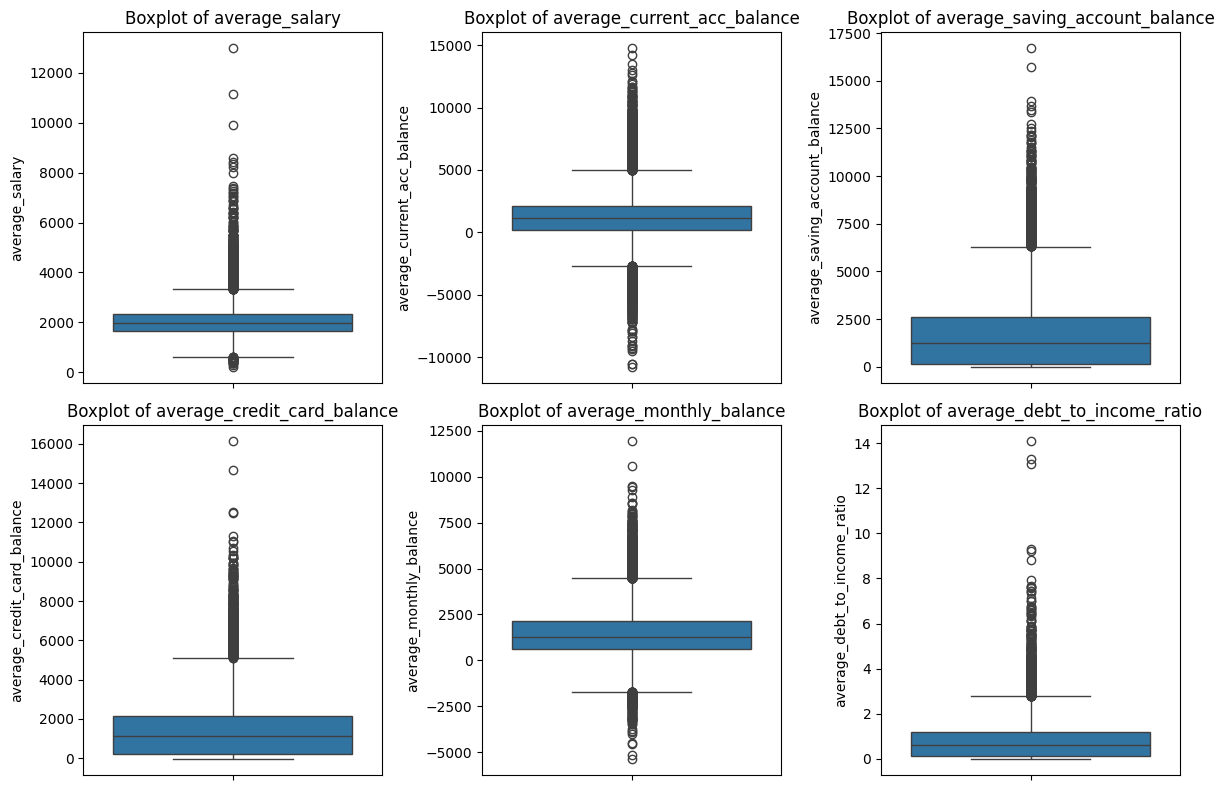

In [49]:
# Plot boxplots for each column to visualize the outliers
plt.figure(figsize=(12, 8))
for idx, num_feat in enumerate(num_feats, 1):
    plt.subplot(2, 3, idx)
    sns.boxplot(y=customer_averages[num_feat])
    plt.title(f"Boxplot of {num_feat}")

plt.tight_layout()
plt.show()

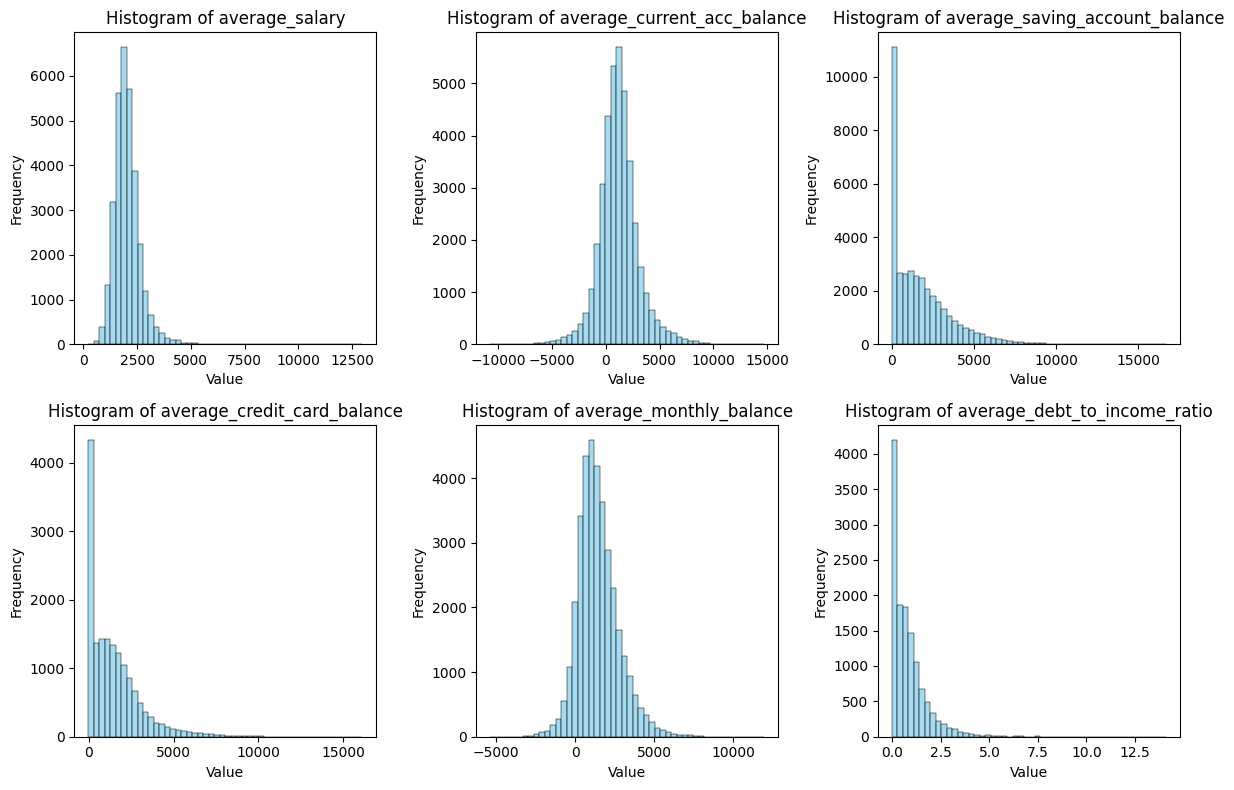

In [50]:
# Plot histograms for each numerical features to visualize the outliers
plt.figure(figsize=(12, 8))
for idx, num_feat in enumerate(num_feats, 1):
    plt.subplot(2, 3, idx)
    sns.histplot(customer_averages[num_feat], kde=False, bins=50, color="skyblue")
    plt.title(f"Histogram of {num_feat}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# average_saving_account_balance, average_credit_card_balance, and average_debt_to_income_ratio 
# HAS HIGHLY SKEWED DISTRIBUTION

In [51]:
# Find and print outliers for each numerical features
for num_feat in num_feats:
    lower_bound, upper_bound, outliner_num, _ = detect_outliers_iqr(customer_averages, num_feat)
    print(f"Total number of outliers for {num_feat}: {outliner_num}")
    print(f"Non-Outlier bounds for {num_feat}: [{lower_bound}-{upper_bound}]")
    print(50*"-")

Total number of outliers for average_salary: 1049
Non-Outlier bounds for average_salary: [619.1339819004521-3339.560226244344]
--------------------------------------------------
Total number of outliers for average_current_acc_balance: 2074
Non-Outlier bounds for average_current_acc_balance: [-2703.0705-4999.800833333333]
--------------------------------------------------
Total number of outliers for average_saving_account_balance: 908
Non-Outlier bounds for average_saving_account_balance: [-3583.399981060606-6310.154412878788]
--------------------------------------------------
Total number of outliers for average_credit_card_balance: 552
Non-Outlier bounds for average_credit_card_balance: [-2740.4009090909094-5113.344545454545]
--------------------------------------------------
Total number of outliers for average_monthly_balance: 1064
Non-Outlier bounds for average_monthly_balance: [-1710.0158890374332-4470.208442513369]
--------------------------------------------------
Total number

### More Feature Engineering

In [52]:
# First explore the number of outliers belongs to all numerical features.
_, _, _, outliers_average_salary = detect_outliers_iqr(customer_averages, "average_salary")
_, _, _, outliers_average_current_acc_balance = detect_outliers_iqr(customer_averages, \
    "average_current_acc_balance")
_, _, _, outliers_average_saving_account_balance = detect_outliers_iqr(customer_averages, \
    "average_saving_account_balance")
_, _, _, outliers_average_credit_card_balance = detect_outliers_iqr(customer_averages, \
    "average_credit_card_balance")
_, _, _, outliers_average_monthly_balance = detect_outliers_iqr(customer_averages, \
    "average_monthly_balance")
_, _, _, outliers_average_debt_to_income_ratio = detect_outliers_iqr(customer_averages, \
    "average_debt_to_income_ratio")

In [53]:
# Take the union of these tree outlier spaces
outlier_union = pd.concat([outliers_average_salary, outliers_average_current_acc_balance, \
    outliers_average_saving_account_balance, outliers_average_credit_card_balance, \
        outliers_average_monthly_balance, outliers_average_debt_to_income_ratio]).\
        drop_duplicates(keep="first")
outlier_union

,cust_id,date,average_salary,average_current_acc_balance,average_saving_account_balance,average_credit_card_balance,loan_date,is_after_loan_date,average_monthly_balance,average_debt_to_income_ratio
41,41,2017-06-01 05:20:00.000000000,3462.815926,8141.390370,0.0000,NaN,2018-07-01,0.0,4070.695185,NaN
95,95,2016-12-31 03:50:24.000000000,3379.254400,3964.624000,1550.9616,NaN,2018-01-01,0.0,2757.792800,NaN
251,251,2016-01-16 12:00:00.000000000,3717.105000,1369.300000,3501.9000,NaN,2016-02-01,0.0,2435.600000,NaN
286,286,2017-12-31 08:00:00.000000000,3858.378889,3152.751111,0.0000,0.000000,2018-05-01,0.0,1576.375556,0.000000
289,289,2016-03-16 20:00:00.000000000,3991.523333,-482.578333,NaN,2568.951667,2016-06-01,0.0,NaN,1.175096
...,...,...,...,...,...,...,...,...,...,...
38886,38886,2016-05-01 13:20:00.000000000,873.337778,278.011111,0.0000,2854.197778,2016-09-01,0.0,139.005556,3.280534
38936,38936,2018-03-02 01:15:47.368421120,1134.497368,1147.830526,0.0000,3269.618421,NaT,0.0,573.915263,3.136308
38957,38957,2016-11-15 21:00:00.000000000,1800.545000,1653.426250,738.9025,5030.807500,2017-03-01,0.0,1196.164375,2.842575
39466,39466,2016-08-31 11:04:36.923076864,812.312308,314.620769,NaN,3420.007692,2017-03-01,0.0,NaN,4.208371


In [54]:
# Eliminate outliers from loan_data
customer_averages = pd.concat([customer_averages, outlier_union]).drop_duplicates(keep=False)
customer_averages

,cust_id,date,average_salary,average_current_acc_balance,average_saving_account_balance,average_credit_card_balance,loan_date,is_after_loan_date,average_monthly_balance,average_debt_to_income_ratio
0,0,2017-06-16 10:40:00.000000000,1333.446111,1904.599722,4470.665278,NaN,NaT,0.0,3187.632500,NaN
1,1,2017-05-01 18:54:32.727272704,NaN,1832.253939,NaN,NaN,2018-09-01,0.0,NaN,NaN
2,2,2016-02-15 12:00:00.000000000,NaN,755.230000,2786.745000,NaN,2016-04-01,0.0,1770.987500,NaN
3,3,2016-04-16 06:00:00.000000000,1584.795000,-675.707500,23.578750,NaN,2016-08-01,0.0,-326.064375,NaN
4,4,2016-09-30 19:45:52.941176576,1527.442353,1550.418235,1444.917059,1761.714706,2017-06-01,0.0,1497.667647,1.496681
...,...,...,...,...,...,...,...,...,...,...
39994,39994,2016-08-01 01:36:00.000000000,3111.351333,-162.762667,1410.700000,NaN,2017-03-01,0.0,623.968667,NaN
39995,39995,2016-12-15 22:00:00.000000000,1543.714583,-1155.817083,2489.885833,NaN,2017-12-01,0.0,667.034375,NaN
39996,39996,2016-04-16 06:00:00.000000000,1738.207500,1685.361250,2978.980000,NaN,2016-08-01,0.0,2332.170625,NaN
39998,39998,2016-09-30 18:56:50.526315776,NaN,560.767895,2124.778421,NaN,2017-07-01,0.0,1342.773158,NaN


In [55]:
customer_averages.columns

Index(['cust_id', 'date', 'average_salary', 'average_current_acc_balance',
       'average_saving_account_balance', 'average_credit_card_balance',
       'loan_date', 'is_after_loan_date', 'average_monthly_balance',
       'average_debt_to_income_ratio'],
      dtype='object')

In [56]:
# Save the modified DataFrame to a new CSV file
customer_averages[["cust_id", "average_salary", "average_current_acc_balance", "average_saving_account_balance", \
    "average_credit_card_balance", "average_monthly_balance", "average_debt_to_income_ratio"]].to_csv(\
        "../processed_data/customer_financials.csv", index=False)

## Dataset of loan_delinquencies.csv

In [57]:
# Load the data
file_name = "../data/loan_deliquencies.csv"
deliq_data = pd.read_csv(file_name)

deliq_data

,loan_id,start_date,end_date
0,222998,2018-10-01,2019-02-01
1,222992,2016-11-01,2017-03-01
2,222986,2018-06-01,2018-09-01
3,222980,2017-01-01,2017-04-01
4,222974,2016-11-01,2017-02-01
...,...,...,...
15280,103043,2018-03-01,2018-04-01
15281,103025,2017-07-01,2017-11-01
15282,103016,2018-09-01,2018-10-01
15283,103013,2017-04-01,2017-06-01


#### Feature Engineering

In [58]:
deliq_data["start_date"] = pd.to_datetime(deliq_data["start_date"])
deliq_data["end_date"] = pd.to_datetime(deliq_data["end_date"])

In [59]:
# Calculate the difference in months
deliq_data["delinquency"] = ((deliq_data["end_date"] - deliq_data["start_date"])\
    .dt.days // 30).astype(int)

# Calculate the default in loans
deliq_data["is_default"] = deliq_data["delinquency"].apply(lambda row: 1 if row > 3 \
    else 0)
deliq_data

,loan_id,start_date,end_date,delinquency,is_default
0,222998,2018-10-01,2019-02-01,4,1
1,222992,2016-11-01,2017-03-01,4,1
2,222986,2018-06-01,2018-09-01,3,0
3,222980,2017-01-01,2017-04-01,3,0
4,222974,2016-11-01,2017-02-01,3,0
...,...,...,...,...,...
15280,103043,2018-03-01,2018-04-01,1,0
15281,103025,2017-07-01,2017-11-01,4,1
15282,103016,2018-09-01,2018-10-01,1,0
15283,103013,2017-04-01,2017-06-01,2,0


#### EDA

In [60]:
# Check data types
deliq_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15285 entries, 0 to 15284
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   loan_id      15285 non-null  int64         
 1   start_date   15285 non-null  datetime64[ns]
 2   end_date     15285 non-null  datetime64[ns]
 3   delinquency  15285 non-null  int64         
 4   is_default   15285 non-null  int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 597.2 KB


In [61]:
# Calculate the percentage of missing values for each column
missing_percentage = (deliq_data.isna().mean() * 100).round(2)

# Display the result
print("Missing Value Percentage for Each Column:")
print(missing_percentage)

Missing Value Percentage for Each Column:
loan_id        0.0
start_date     0.0
end_date       0.0
delinquency    0.0
is_default     0.0
dtype: float64


/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ipykernel_14218/2308103933.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="is_default", data=deliq_data, palette="viridis")
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  

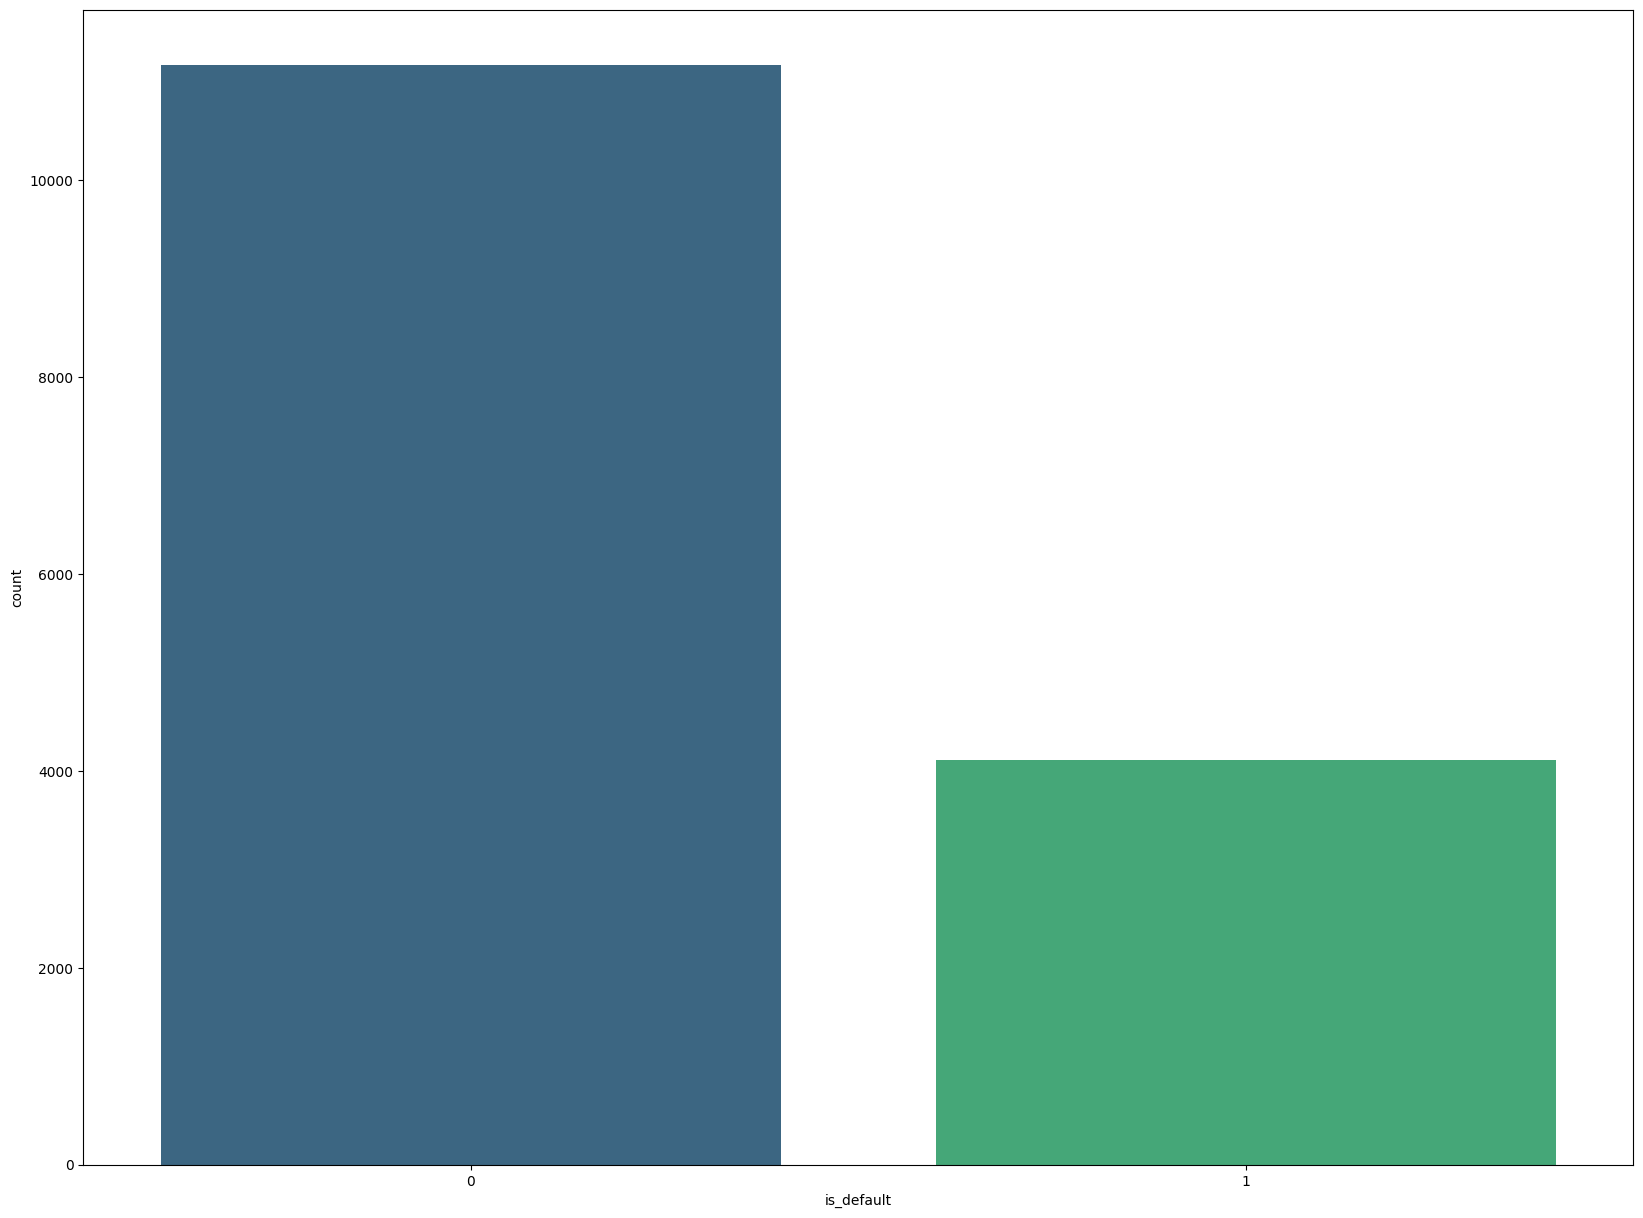

In [62]:
# Plot count plots for value counts for our label to see if there is imbalance
plt.figure(figsize=(20, 15))
sns.countplot(x="is_default", data=deliq_data, palette="viridis")

plt.show()

# I WILL ASSUME THAT ALL THE REMANING LOANS FROM 40 THOUSANDS ARE ALSO NON-DEFAULT.
# THAT'S WHY OUT LABEL IS ACTUALLY HIGHLY IMBALANCED.

In [63]:
assert (deliq_data["delinquency"].unique() < 5).any(), "ERROR"